In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import defmod.model_graddesc as model
import scipy.optimize


torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
nb_pts1 = 10
nb_pts2 = 7
dim = 2

o1 = torch.tensor([0.,-1.])
o2 = torch.tensor([3.,3.])
origin = [o1,o2]
r1 = 2
r2 = 1
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

#origin_target = [[10., 0.], [0, 5.]]
origin_target = [[0.,2.], [3.,-2.]]

target = mm.multipleCircles(origin_target, radius, nb_pts)

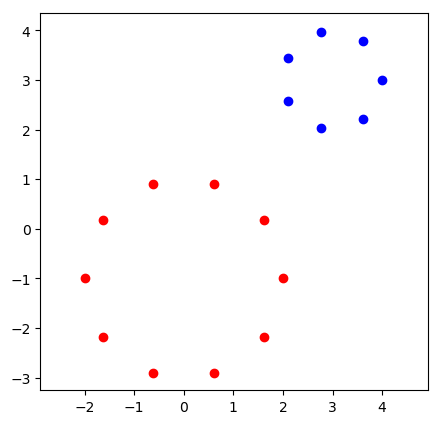

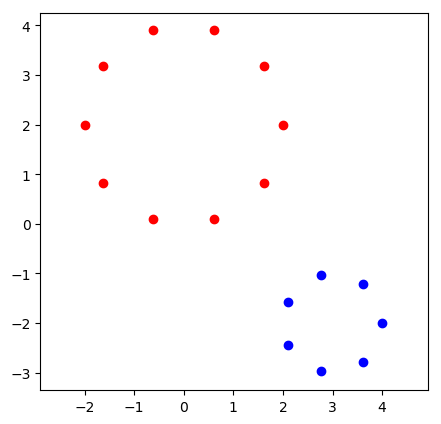

In [3]:
figsize = (5,5)
dpi = 100

fig_source = plt.figure(figsize=figsize, dpi=100)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

fig_target = plt.figure(figsize=figsize, dpi=100)
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [16]:
# Defining the deformation modules
sigma1 = 20
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.GlobalTranslation(manifold1, sigma1)
trans1.fill_controls_zero()
#trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
mod1 = dm.deformationmodules.CompoundModule([trans1])

sigma2 = 20
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.GlobalTranslation(manifold2, sigma2)
trans2.fill_controls_zero()
#trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
mod2 = dm.deformationmodules.CompoundModule([trans2])

module_list = [mod1, mod2]
sigma_bg = 1.
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [17]:
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [6]:
# set parameters
reg_param = 10**-3 

gd0_tensor = torch.cat([source[0], source[1], source[0], source[1]],0).requires_grad_().view(-1)
mom0_tensor = torch.zeros(gd0_tensor.shape).requires_grad_().view(-1)
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id, source, target, dim, reg_param)
X = [gd0_tensor, mom0_tensor]

In [22]:
def fun(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return EnergyFunctional.energy_tensor(gd0_tensor, Y).detach().numpy()

def jac(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return EnergyFunctional.gradE_autograd(gd0_tensor, Y).detach().numpy()


args = [EnergyFunctional]

P = mom0_tensor.detach().numpy()

In [23]:
fun(P)

cost: 0.0 attach: 22.71558953582809


array(22.71558953582809)

In [24]:
res = scipy.optimize.minimize(fun, mom0_tensor.detach().numpy(),
                              method='BFGS',
                              jac=jac,
                              bounds=None,
                              tol=None,
                              callback=None,
                              options={
                                  #'maxcor': 10,
                                  #'ftol': 1.e-09,
                                  'gtol': 1e-03,
                                  'eps': 1e-08,
                                  #'maxfun': 500,
                                  'maxiter': 50,
                                  #'iprint': 1,
                                  #'maxls': 25
                                  'disp' : True
                              })

cost: 0.0 attach: 22.71558953582809
cost: 0.0 attach: 22.71558953582809
cost: 0.00192294921507 attach: 18.87081793742275
cost: 0.00192294921507 attach: 18.87081793742275
cost: 0.0276610035614 attach: 15.122027075301803
cost: 0.0276610035614 attach: 15.122027075301803
cost: 0.154083437053 attach: 9.075650900155303
cost: 0.154083437053 attach: 9.075650900155303
cost: 0.027184647567 attach: 11.260189377004417
cost: 0.027184647567 attach: 11.260189377004417
cost: 0.805599189576 attach: 12.940984304750856
cost: 0.805599189576 attach: 12.940984304750856
cost: 0.155509466766 attach: 8.828623362965544
cost: 0.155509466766 attach: 8.828623362965544
cost: 0.194274658364 attach: 24.702163769608934
cost: 0.194274658364 attach: 24.702163769608934
cost: 0.141414929535 attach: 9.807075781374193
cost: 0.141414929535 attach: 9.807075781374193
cost: 0.149003617225 attach: 8.700462967010706
cost: 0.149003617225 attach: 8.700462967010706
cost: 0.146671348826 attach: 8.430267412237399
cost: 0.146671348826 

cost: 0.0908919216986 attach: 4.325923290701787e-09
cost: 0.0908919217046 attach: 2.9960919027004977e-09
cost: 0.0908919217046 attach: 2.9960919027004977e-09
cost: 0.0908919217244 attach: 2.9130539764518157e-09
cost: 0.0908919217244 attach: 2.9130539764518157e-09
cost: 0.0908919217256 attach: 2.786361686671402e-09
cost: 0.0908919217256 attach: 2.786361686671402e-09
cost: 0.0908919217308 attach: 2.409151841821806e-09
cost: 0.0908919217308 attach: 2.409151841821806e-09
cost: 0.0908919217334 attach: 2.186650240921201e-09
cost: 0.0908919217334 attach: 2.186650240921201e-09
cost: 0.0908919217329 attach: 1.7865832140258226e-09
cost: 0.0908919217329 attach: 1.7865832140258226e-09
cost: 0.0908919217287 attach: 1.0435578180915304e-09
cost: 0.0908919217287 attach: 1.0435578180915304e-09
         Current function value: 0.090892
         Iterations: 50
         Function evaluations: 89
         Gradient evaluations: 89


In [25]:
X[1] = torch.tensor(res.x)

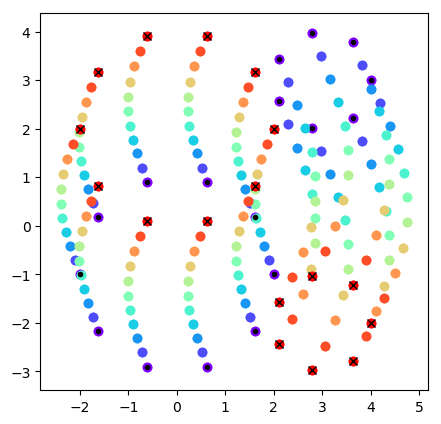

In [26]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])

states, controls = dm.shooting.shoot_euler(H, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

fig_shooting = plt.figure(figsize = figsize, dpi=100)
for s,c in zip(states, colors):
    plt.scatter(s[0][0].gd.view(-1,2)[:, 0].detach().numpy(), s[0][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[1][0].gd.view(-1,2)[:, 0].detach().numpy(), s[1][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show()

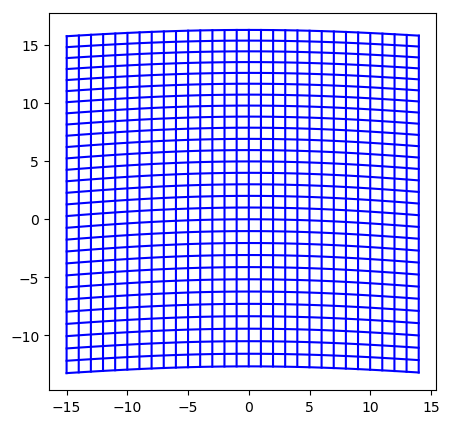

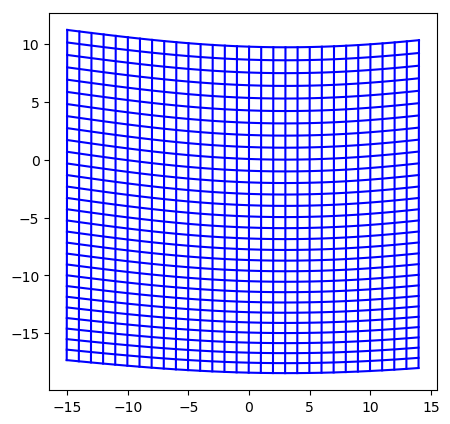

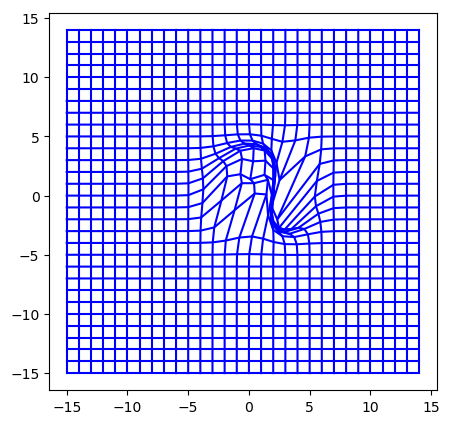

In [27]:
# Visualization of grid deformation for each submodule
nx, ny = 30, 30
sx, sy = 30, 30
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.DoubleTensor)/nx - 0.5)
y = sy*(y.type(torch.DoubleTensor)/ny - 0.5)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.DoubleTensor)


phi = mm.largeDeformation(modules, states, controls, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(phi[0], nx, ny)
x2, y2 = dm.usefulfunctions.vec2grid(phi[1], nx, ny)
x3, y3 = dm.usefulfunctions.vec2grid(phi[2], nx, ny)



fig_grid1 = mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
fig_grid2 = mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
fig_grid_bg = mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
plt.show()


In [77]:
## LDDMM Module

man_compound = dm.manifold.Landmarks(2, manifold1.nb_pts + manifold2.nb_pts, gd = torch.cat(source).view(-1))
module_LDDMM = dm.deformationmodules.Translations(man_compound, sigma=sigma_bg)
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

Energy_LDDMM = model.EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, source, target, dim=2, gamma=reg_param, attach=None)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

P = mom0.detach().numpy()
def fun_LDDMM(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return Energy_LDDMM.energy_tensor(gd0, Y).detach().numpy()

def jac_LDDMM(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return Energy_LDDMM.gradE_autograd(gd0, Y).detach().numpy()


#args = [EnergyFunctional]

In [78]:
## Optimisation for LDDMM
res_LDDMM = scipy.optimize.minimize(fun_LDDMM, mom0.detach().numpy(),
                              method='BFGS',
                              jac=jac_LDDMM,
                              bounds=None,
                              tol=None,
                              callback=None,
                              options={
                                  #'maxcor': 10,
                                  #'ftol': 1.e-09,
                                  'gtol': 1e-03,
                                  'eps': 1e-08,
                                  #'maxfun': 500,
                                  'maxiter': 50,
                                  #'iprint': 1,
                                  #'maxls': 25
                                  'disp' : True
                              })

cost: 0.0 attach: 16.278820596099706
cost: 0.0 attach: 16.278820596099706
cost: 0.00154762381877 attach: 13.565241898898373
cost: 0.00154762381877 attach: 13.565241898898373
cost: 0.0143756645309 attach: 9.537446758114301
cost: 0.0143756645309 attach: 9.537446758114301
cost: 0.0612364541148 attach: 7.700133146965819
cost: 0.0612364541148 attach: 7.700133146965819
cost: 0.0427745871445 attach: 6.211810851656874
cost: 0.0427745871445 attach: 6.211810851656874
cost: 0.0281482277553 attach: 7.151347416189078
cost: 0.0281482277553 attach: 7.151347416189078
cost: 0.0376799823035 attach: 5.7901908438151155
cost: 0.0376799823035 attach: 5.7901908438151155
cost: 0.0367674893941 attach: 5.005306936348133
cost: 0.0367674893941 attach: 5.005306936348133
cost: 0.0377799101508 attach: 5.245970008368311
cost: 0.0377799101508 attach: 5.245970008368311
cost: 0.0367977654753 attach: 4.639519074033449
cost: 0.0367977654753 attach: 4.639519074033449
cost: 0.0400173203674 attach: 4.089527841102849
cost: 0.

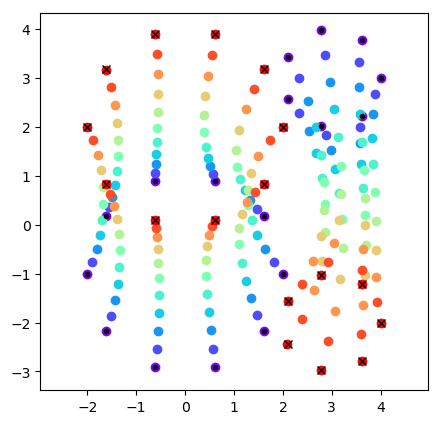

In [83]:
X_LDDMM[1] = torch.tensor(res_LDDMM.x)

H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])

states, controls = dm.shooting.shoot_euler(H_LDDMM, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

fig_shooting = plt.figure(figsize = figsize, dpi=100)
for s,c in zip(states, colors):
    plt.scatter(s[0].gd.view(-1,2)[:, 0].detach().numpy(), s[0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show()

In [ ]:
# Visualization of grid deformation for each submodule
nx, ny = 30, 30
sx, sy = 30, 30
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.DoubleTensor)/nx - 0.5)
y = sy*(y.type(torch.DoubleTensor)/ny - 0.5)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.DoubleTensor)


phi = mm.largeDeformation_unconstrained(module_compound, states, controls, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(phi, nx, ny)

fig_grid1 = mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
plt.show()


In [28]:
## Unconstrained Compound Module

man_compound = dm.manifold.Landmarks(2, manifold1.nb_pts + manifold2.nb_pts, gd = torch.cat(source).view(-1))
trans1_comp = dm.deformationmodules.GlobalTranslation(manifold1, sigma = 10.)
trans1_comp.fill_controls_zero()
trans2_comp = dm.deformationmodules.GlobalTranslation(manifold2, sigma = 10.)
trans2_comp.fill_controls_zero()

module_compound = dm.deformationmodules.CompoundModule([trans1_comp, trans2_comp])
H_compound = dm.hamiltonian.Hamiltonian(module_compound)

attach = dm.attachement.L2NormAttachement()
Energy_compound = model.EnergyFunctional_unconstrained(module_compound, H_compound, source, target, dim=2, gamma=reg_param, attach=attach)
gd0_c = torch.cat(module_compound.manifold.unroll_gd())
mom0_c = torch.cat(module_compound.manifold.unroll_cotan())
X_compound = [gd0_c, mom0_c]

def fun_compound(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return Energy_compound.energy_tensor(gd0_c, Y).detach().numpy()

def jac_compound(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return Energy_compound.gradE_autograd(gd0_c, Y).detach().numpy()


#args = [EnergyFunctional]

In [29]:
## Optimisation for unconstrained compound
res_compound = scipy.optimize.minimize(fun_compound, mom0_c.detach().numpy(),
                              method='BFGS',
                              jac=jac_compound,
                              bounds=None,
                              tol=None,
                              callback=None,
                              options={
                                  #'maxcor': 10,
                                  #'ftol': 1.e-09,
                                  'gtol': 1e-03,
                                  'eps': 1e-08,
                                  #'maxfun': 500,
                                  'maxiter': 500,
                                  #'iprint': 1,
                                  #'maxls': 25
                                  'disp' : True
                              })

cost: 41.7613823824 attach: 49706.35778597095
cost: 41.7613823824 attach: 49706.35778597095
cost: 41.5517720931 attach: 47246.006144150946
cost: 41.5517720931 attach: 47246.006144150946
cost: 41.0131257652 attach: 258017.19734305033
cost: 41.0131257652 attach: 258017.19734305033
cost: 41.5398370228 attach: 47057.886333193004
cost: 41.5398370228 attach: 47057.886333193004
cost: 41.5298739026 attach: 46926.032361142185
cost: 41.5298739026 attach: 46926.032361142185
cost: 41.2148955472 attach: 412733.1560373368
cost: 41.2148955472 attach: 412733.1560373368
cost: 41.5289493716 attach: 46913.61505773968
cost: 41.5289493716 attach: 46913.61505773968
cost: 41.5280281665 attach: 46901.20224082946
cost: 41.5280281665 attach: 46901.20224082946
cost: 41.3574511253 attach: 112202.31929098952
cost: 41.3574511253 attach: 112202.31929098952
cost: 41.4878888275 attach: 46290.466803039715
cost: 41.4878888275 attach: 46290.466803039715
cost: 41.4506101282 attach: 45663.54296327608
cost: 41.4506101282 at

cost: 559.539480367 attach: 1173.4689181278109
cost: 559.539480367 attach: 1173.4689181278109
cost: 558.553763293 attach: 1173.777434818487
cost: 558.553763293 attach: 1173.777434818487
cost: 557.940680775 attach: 1173.7716619208918
cost: 557.940680775 attach: 1173.7716619208918
cost: 555.493241918 attach: 1173.4339268826704
cost: 555.493241918 attach: 1173.4339268826704
cost: 545.781745917 attach: 11692.418620214494
cost: 545.781745917 attach: 11692.418620214494
cost: 553.139878057 attach: 1157.5698567251889
cost: 553.139878057 attach: 1157.5698567251889
cost: 550.413141342 attach: 1167.4797701545654
cost: 550.413141342 attach: 1167.4797701545654
cost: 552.66113992 attach: 1158.543261148664
cost: 552.66113992 attach: 1158.543261148664
cost: 552.964004617 attach: 1157.0843774328114
cost: 552.964004617 attach: 1157.0843774328114
cost: 542.698191025 attach: 1189.7538970878259
cost: 542.698191025 attach: 1189.7538970878259
cost: 552.962442296 attach: 1157.0833162088334
cost: 552.962442296

cost: 349.960248281 attach: 1025.786618861171
cost: 349.960248281 attach: 1025.786618861171
cost: 349.829135564 attach: 1025.6562768637866
cost: 349.829135564 attach: 1025.6562768637866
cost: 350.185272635 attach: 1024.8096372030245
cost: 350.185272635 attach: 1024.8096372030245
cost: 351.655874644 attach: 1022.21561207943
cost: 351.655874644 attach: 1022.21561207943
cost: 357.614972282 attach: 1007.7361729216088
cost: 357.614972282 attach: 1007.7361729216088
cost: 382.678396498 attach: 960.9144167795125
cost: 382.678396498 attach: 960.9144167795125
cost: 373.825397934 attach: 968.2917511866951
cost: 373.825397934 attach: 968.2917511866951
cost: 351.352996157 attach: 1008.2467843544484
cost: 351.352996157 attach: 1008.2467843544484
cost: 372.622473922 attach: 969.624292838052
cost: 372.622473922 attach: 969.624292838052
cost: 373.484728966 attach: 968.6073539251056
cost: 373.484728966 attach: 968.6073539251056
cost: 373.135771179 attach: 968.9066059697516
cost: 373.135771179 attach: 96

KeyboardInterrupt: 

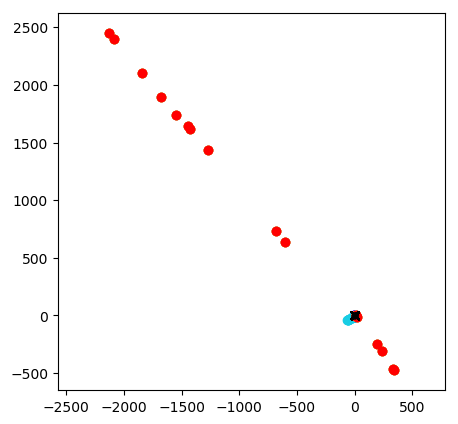

In [30]:
X_compound[1] = torch.tensor(res_compound.x)

H_compound.module.manifold.fill_gd(X_compound[0])
H_compound.module.manifold.fill_cotan(X_compound[1])

states, controls = dm.shooting.shoot_euler(H_compound, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

fig_shooting = plt.figure(figsize = figsize, dpi=100)
for s,c in zip(states, colors):
    plt.scatter(s[0].gd.view(-1,2)[:, 0].detach().numpy(), s[0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[1].gd.view(-1,2)[:, 0].detach().numpy(), s[1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)

    plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show()

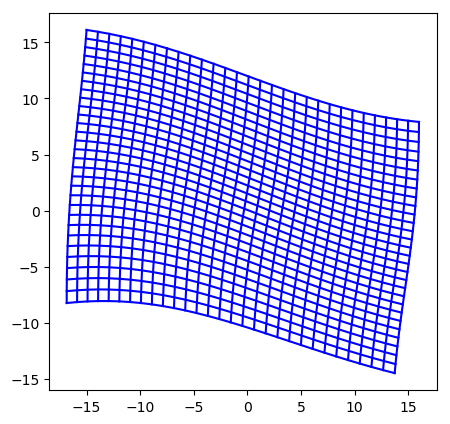

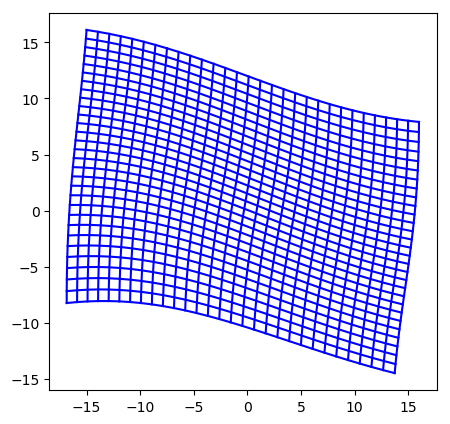

In [23]:
# Visualization of grid deformation for each submodule
nx, ny = 30, 30
sx, sy = 30, 30
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.DoubleTensor)/nx - 0.5)
y = sy*(y.type(torch.DoubleTensor)/ny - 0.5)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.DoubleTensor)


phi = mm.largeDeformation_unconstrained(module_compound, states, controls, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(phi, nx, ny)

fig_grid1 = mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
plt.show()


In [9]:
def compute_deformation_grid(grid_origin, grid_size, grid_resolution, it=2, intermediate=False):
    x, y = torch.meshgrid([
        torch.linspace(grid_origin[0], grid_origin[0]+grid_size[0], grid_resolution[0]),
        torch.linspace(grid_origin[1], grid_origin[1]+grid_size[1], grid_resolution[1])])

    gridpos = dm.usefulfunctions.grid2vec(x, y)

    grid_landmarks = dm.manifold.Landmarks(2, gridpos.shape[0], gd=gridpos.view(-1))
    grid_silent = dm.deformationmodules.SilentPoints(grid_landmarks)

    intermediate = dm.shooting.shoot_euler(dm.hamiltonian_multishape.Hamiltonian_multi(dm.multishape.MultiShapeModule([grid_silent, *modules.module_list]), constr_Id), it=10)

    return dm.usefulfunctions.vec2grid(grid_landmarks.gd.view(-1, 2).detach(), grid_resolution[0], grid_resolution[1])

compute_deformation_grid(torch.tensor([-3.,-3.]), torch.tensor([15.,10.]), torch.Size([16,16]))

AttributeError: 'SilentPoints' object has no attribute 'module_list'

In [ ]:
fig_shooting.savefig('results/circles_translation/shooting.png')
fig_source.savefig('results/circles_translation/source.png')
fig_target.savefig('results/circles_translation/target.png')

fig_grid1.savefig('results/circles_translation/grid1.png')
fig_grid2.savefig('results/circles_translation/grid2.png')
fig_grid_bg.savefig('results/circles_translation/grid_bg.png')

In [18]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
        
        return H()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
gd = gd0_tensor
mom = 1000*torch.rand(gd.shape)


test_gradcheck_Hamiltonian()

True

In [116]:
# Defining the deformation modules
sigma1 = 5.
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1).clone().requires_grad_())
trans1 = dm.deformationmodules.GlobalTranslation(manifold1, sigma1)
trans1.fill_controls_zero()
#trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
silent1 = dm.deformationmodules.SilentPoints(manifold1.copy())
mod1 = dm.deformationmodules.CompoundModule([silent1, trans1, trans2])

sigma_scaling = 1.
a = torch.sqrt(torch.tensor(3.))
direc_scaling_pts = torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=torch.float64)
direc_scaling_vec =  torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=torch.float64)
def f(x):
    centre = x.view(1,2).repeat(3,1)
    return centre + 0.3 * sigma_scaling * direc_scaling_pts

def g(x):
    return direc_scaling_vec
scaling0 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = torch.tensor([0.,0.]).view(-1).requires_grad_()), f, g, sigma_scaling)

man_scal = dm.manifold.Landmarks(2,1, gd=torch.tensor([0.,0.]).view(-1).requires_grad_())
scal = dm.deformationmodules.LocalScaling(man_scal, sigma=5.)
sigma2 = 1.
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1).clone().requires_grad_())
trans2 = dm.deformationmodules.GlobalTranslation(manifold2, sigma2)
trans2.fill_controls_zero()
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
silent2 = dm.deformationmodules.SilentPoints(manifold2.copy())
mod2 = dm.deformationmodules.CompoundModule([ silent2, trans2])


module_list = [mod1]
sigma_bg = 5.
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr_Id = dm.constraints.Identity_Silent()
H_check = hamiltonian.Hamiltonian_multi(modules, constr_Id)

H_check = dm.hamiltonian.Hamiltonian(module_list)

In [144]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H_check.module.manifold.fill_gd(gd)
        H_check.module.manifold.fill_cotan(mom)
        H_check.geodesic_controls()
        
        return H_check()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd0_tensor = torch.cat(H_check.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
gd = gd0_tensor
mom = 1000*torch.rand(gd.shape)


test_gradcheck_Hamiltonian()

True

In [ ]:
H.module.module_list[0].module_list, H.module.module_list[1].module_list, H.module.module_list[2].module_list

In [53]:
H_check.module.module_list[0].module_list, H.module.module_list[1].module_list, H_check.module.module_list[-1].module_list

([<defmod.deformationmodules.SilentPoints at 0x7feca7689438>,
  <defmod.deformationmodules.Translations at 0x7feca1292f60>])

In [54]:
H_check.module.manifold[-1].manifold_list